In [3]:
import pandas as pd
import numpy as np
import glob
import gc
import keras 
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, MaxPooling2D, Conv2D, Input
from keras.layers import Flatten, BatchNormalization, Activation, Reshape, concatenate
from keras.models import Model
import random
import keras.backend as K

Using TensorFlow backend.


In [4]:
spectrums_index = np.array(glob.glob('../preparations/spectrograms/*'))
labels_index = np.array(glob.glob('../preparations/labels/*'))

In [5]:
num_samples = 5000
height = 108
width = 108
steps = 20
spec_list = spectrums_index[:num_samples]
labe_list = labels_index[:num_samples]

In [6]:
# function to generate inputs to model

def inputs_to_model(spectrum_list, labels_list, order, num, start, ending):
    lstm_output = []
    cnn_output = []
    y_train = []
    
    import time
    start_ = time.time()

    for file in order[num][start:ending]:
        spectrum = np.load(spectrum_list[file])
        labels = np.load(labels_list[file])
        
        _lstm = np.zeros((20, 24))
        for count, i in enumerate(labels):
            _cnn = spectrum[:, 27*count:108+27*count]
            if _cnn.shape == (height, width):
                lstm_output.append(_lstm)
                cnn_output.append(_cnn.reshape((height, width, 1)))
                y_train.append(i)
        
            _lstm = _lstm[1:, :]
            _lstm = np.append(_lstm, i.reshape((1, 24)), axis=0)
        
    lstm_inputs = np.array(lstm_output)
    cnn_inputs = np.array(cnn_output)
    labels_inputs = np.array(y_train)
    print(time.time()-start_)
    return lstm_inputs, cnn_inputs, labels_inputs

In [7]:
def classifier_1(optimizer='adam', loss='binary_crossentropy', metrix='accuracy'):
    #cnn
    cnn_inputs = Input(shape=(height, width, 1), name='cnn_inputs')
    layers = BatchNormalization()(cnn_inputs)
    layers = Conv2D(32, (3,3), padding="same", activation="relu")(layers)
    layers = MaxPooling2D(2,2, border_mode='same')(layers)
    layers = Conv2D(32, (3,3), activation='relu')(layers)
    layers = BatchNormalization()(layers)
    layers = MaxPooling2D(2,2, border_mode='same')(layers)
    layers = Flatten()(layers)
    layers = Dropout(0.3)(layers)
    layers = Dense(32, activation='relu')(layers)
    
    #lstm
    lstm_inputs = Input(shape=(steps, 24), name='lstm_inputs')
    lstm_layers = LSTM(16, return_sequences=True)(lstm_inputs)
    lstm_layers = LSTM(16)(lstm_layers)
    lstm_layers = Dense(24, activation='relu')(lstm_layers)
    
    #main route
    main_ = concatenate([lstm_layers, layers])
    main_ = BatchNormalization()(main_)
    main_ = Dense(64, activation='relu')(main_)
    output = Dense(24, activation='sigmoid')(main_)
    
    model = Model(inputs=[lstm_inputs, cnn_inputs], outputs=[output])
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrix])
    return model

In [8]:
classifier = classifier_1(optimizer='adam')
classifier.load_weights('weights/weight-75overlap-model1.hdf5')

/anaconda3/envs/nd2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`
/anaconda3/envs/nd2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(2, 2, padding="same")`


In [13]:
def give_prediction(classifier, cnn_input, lstm_input):

#     classifier.load_weights(weight_path)
    prediction = classifier.predict([cnn_input, lstm_input])
    output = 'The notes are: C4'
    for i in range(prediction.shape[0]):
        for j in range(prediction.shape[1]):
            if prediction[i][j] < 0.5:
                prediction[i][j] = 0
            elif prediction[i][j] > 0.5:
                prediction[i][j] = 1
                output+='_{}'.format(j+60)
        print(output)
    return prediction

In [15]:
give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))

The notes are: C4


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
!ls ../preparations/label/

In [136]:
import glob

glob_label = glob.glob('../preparations/label/*')
glob_spectrogram = glob.glob('../preparations/spectrogram/*')
glob_notes = glob.glob('../preparations/notes/*.npy')

('../preparations/notes/0C56DC3C436663F5.npy', '../preparations/label/0C56DC3C436663F5.npy', '../preparations/spectrogram/0C56DC3C436663F5.npy')
(74, 2)


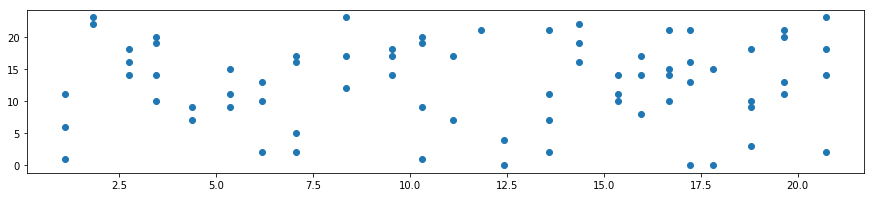

(140, 24)


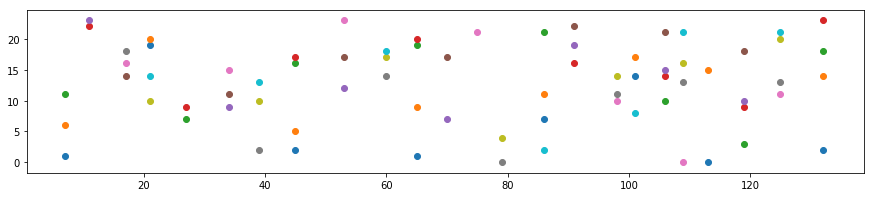

(108, 3446)
(108, 3446)
(108, 1, 108, 124)
(124, 1, 108, 108)
(1, 108, 108)


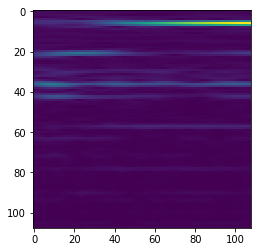

(140, 24)
(20, 24)
(160, 24)
(140, 1, 20, 24)


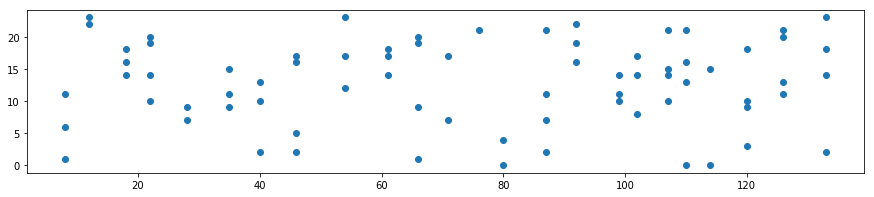

In [186]:
import matplotlib.pyplot as plt

for notes_, label_, spectrogram_ in zip(glob_notes, glob_label, glob_spectrogram)[:1]:
    print(notes_, label_, spectrogram_)
    
    notes = np.load(notes_)
    label = np.load(label_)
    spectrogram = np.load(spectrogram_)
    
    
    print(np.shape(notes))
    plt.figure(figsize=(15,3))
    plt.scatter(notes[:,0],notes[:,1])
    plt.show()
    
    
    print(np.shape(label))
    plt.figure(figsize=(15,3))
    for i,time_slice in enumerate(label):
        for j,note in enumerate(time_slice):
            if note != 0:
                plt.scatter(i,j)
    plt.show()
    
    
    print(np.shape(spectrogram))
    print(np.shape(spectrogram[:,:]))
    cnn_inputs = np.array(zip([spectrogram[:,i:-108+i:27] for i in range(108)]))
    print(np.shape(cnn_inputs))
    cnn_inputs = np.swapaxes(cnn_inputs,0,3)
    print(np.shape(cnn_inputs))
    cnn_inputs = [cnn_input for cnn_input in cnn_inputs]
    print(np.shape(cnn_inputs[1]))
    plt.imshow(cnn_inputs[7][0,:,:])
    plt.show()
    
    
    print(np.shape(label))
    print(np.shape(np.zeros((20,24))))
    lstm_label = np.append(np.zeros((20,24)),label,axis=0)
    print(np.shape(lstm_label))
    
    lstm_inputs = np.array(zip([lstm_label[i:-20+i] for i in range(20)]))
    lstm_inputs = np.swapaxes(lstm_inputs,0,2)
    print(np.shape(lstm_inputs))
    
    plt.figure(figsize=(15,3))
    scatter_points = []
    for i,lstm_input in enumerate(lstm_inputs):
        for time_slice in lstm_input[:,-1,:]:
            for j,note in enumerate(time_slice):
#                 print(note)
                if note != 0:
                    scatter_points.append((i,j))
    
    scatter_points = np.transpose(scatter_points)
    plt.scatter(scatter_points[:][0],scatter_points[:][1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4_61_66_71
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4_60_73_76_81
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4_60_75
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
The notes are: C4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

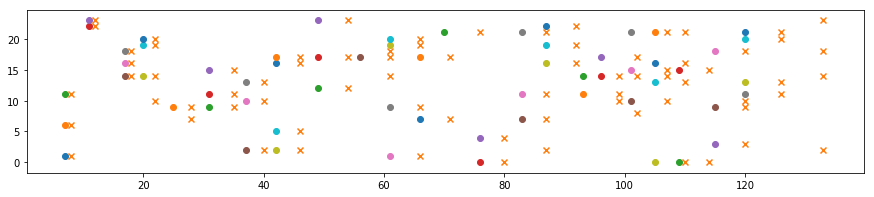

In [187]:
plt.figure(figsize=(15,3))
lstm_memory = np.zeros((1,20,24))
for i,(cnn_input, lstm_input) in enumerate(zip(cnn_inputs, lstm_inputs)[:]):
    
#     print(np.shape(cnn_input))
#     print(np.shape(lstm_input))
#     give_prediction(classifier, np.zeros((1,20,24)), np.zeros((1,108,108,1)))
    print(lstm_input[-1,-1])
#     print(result)
    result = give_prediction(classifier, lstm_memory, cnn_input.reshape((1,108,108,1)))
    lstm_memory[0,:-1] = np.copy(lstm_memory[0,1:])
    lstm_memory[0,-1] = np.copy(result)
    for j, note in enumerate(result[0]):
        if note != 0:
            plt.scatter(i,j)
plt.scatter(scatter_points[0], scatter_points[1], marker='x')
plt.show()

In [143]:
# zip(cnn_inputs, lstm_inputs)

[(array([[[0.00301448, 0.00324074, 0.00377186, ..., 0.0223767 ,
           0.02203025, 0.02172703],
          [0.00899099, 0.0090091 , 0.00895455, ..., 0.01642734,
           0.01610118, 0.01564909],
          [0.00971116, 0.00971558, 0.00958913, ..., 0.00703373,
           0.00735216, 0.00726073],
          ...,
          [0.00484209, 0.00453108, 0.00372113, ..., 0.00055978,
           0.00196671, 0.00267973],
          [0.00112748, 0.00130731, 0.0015531 , ..., 0.00257885,
           0.00252997, 0.00245957],
          [0.00056612, 0.00070754, 0.00099528, ..., 0.00105222,
           0.00039683, 0.00126106]]]),
  array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0.